In [17]:
import numpy as np
import pywt
from PIL import Image
import matplotlib.pyplot as plt

### Đọc ảnh - tiền xử lý ảnh

In [18]:
def load_and_preprocess(image_path: str, size=(256, 256)) -> np.ndarray:
    img = Image.open(image_path).convert("L")   # grayscale
    img = img.resize(size, Image.BILINEAR)
    arr = np.asarray(img, dtype=np.float32)
    return arr

In [19]:
def dwt2(image_arr: np.ndarray, wavelet="haar", level=2):
    return pywt.wavedec2(image_arr, wavelet=wavelet, level=level)

In [20]:
def select_subband(coeffs, band="LL"):
    cA = coeffs[0]  # LL ở level cao nhất (ổn định nhất)
    if band.upper() == "LL":
        return cA
    raise ValueError("Demo này chỉ dùng band='LL'")

In [21]:
def quantize_to_bits(coeff_arr: np.ndarray, method="median") -> np.ndarray:
    flat = coeff_arr.flatten()

    if method == "median":
        thr = np.median(flat)
    elif method == "mean":
        thr = np.mean(flat)
    else:
        raise ValueError("method phải là 'median' hoặc 'mean'")

    bits = (flat > thr).astype(np.uint8)
    return bits


In [ ]:
def to_fixed_length(bits: np.ndarray, hash_bits=256) -> np.ndarray:
    if len(bits) >= hash_bits:
        indices = np.linspace(0, len(bits) - 1, hash_bits, dtype=int)
        return bits[indices].copy()
    out = np.zeros(hash_bits, dtype=np.uint8)
    out[:len(bits)] = bits
    return out

def bits_to_hex(bits: np.ndarray) -> str:
    # pad để chia hết cho 8
    pad_len = (-len(bits)) % 8
    if pad_len:
        bits = np.concatenate([bits, np.zeros(pad_len, dtype=np.uint8)])

    bytes_arr = np.packbits(bits)
    return bytes_arr.tobytes().hex()


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

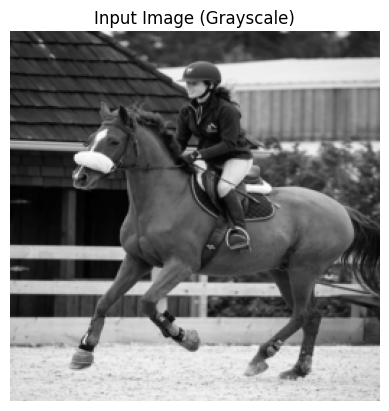

In [23]:
image_path = "./images/horse.jpg"
img = load_and_preprocess(image_path)

plt.imshow(img, cmap="gray")
plt.title("Input Image (Grayscale)")
plt.axis("off")

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

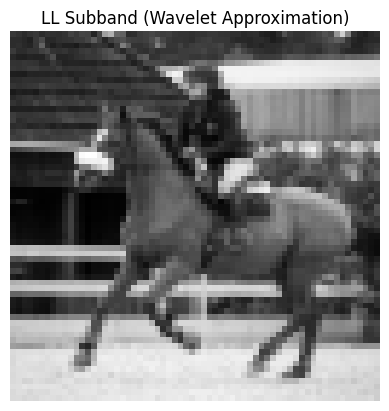

In [24]:
coeffs = dwt2(img, wavelet="haar", level=2)
LL = coeffs[0]   # subband LL

plt.imshow(LL, cmap="gray")
plt.title("LL Subband (Wavelet Approximation)")
plt.axis("off")


In [25]:
def wavelet_hash(
    image_path: str,
    size=(256, 256),
    wavelet="haar",
    level=2,
    band="LL",
    quant_method="median",
    hash_bits=256
):
    img = load_and_preprocess(image_path, size=size)
    coeffs = dwt2(img, wavelet=wavelet, level=level)
    sub = select_subband(coeffs, band=band)
    bits = quantize_to_bits(sub, method=quant_method)
    bits_fixed = to_fixed_length(bits, hash_bits=hash_bits)
    hex_hash = bits_to_hex(bits_fixed)

    return {
        "hash_hex": hex_hash,
        "hash_bits": bits_fixed,
        "subband_shape": sub.shape,
        "wavelet": wavelet,
        "level": level,
        "quant_method": quant_method,
        "hash_bits_len": int(hash_bits),
    }


In [26]:
image_path = "./images/horse.jpg"

r = wavelet_hash(
    image_path,
    wavelet="haar",
    level=2,
    quant_method="median",
    hash_bits=256
)

print("Hash (hex):", r["hash_hex"])
print("Subband shape:", r["subband_shape"])
print("Hash length (bits):", r["hash_bits_len"])


Hash (hex): 4000031111111111111991122223111111731889044fff441bbfbe5fffffffff
Subband shape: (64, 64)
Hash length (bits): 256


In [27]:
def hamming_distance(bits1: np.ndarray, bits2: np.ndarray) -> int:
    if len(bits1) != len(bits2):
        raise ValueError("Hai hash phải cùng độ dài bit")
    return int(np.sum(bits1 != bits2))


In [28]:
img1 = "./images/horse.jpg"
img2 = "./images/horse_modified.jpg"  # ảnh cùng đối tượng nhưng có nhiễu/đổi sáng/resize...


r1 = wavelet_hash(img1)
r2 = wavelet_hash(img2)

print("Hamming distance:", hamming_distance(r1["hash_bits"], r2["hash_bits"]))


Hamming distance: 3
